In [1]:
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

import keras
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.optimizers import Adam
from keras import regularizers
from keras.layers.normalization import BatchNormalization

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from wordcloud import WordCloud
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

from get_labeled_dfs import *
from process_text import *

import spacy
from spacy.pipeline import Tagger

Using TensorFlow backend.


In [2]:
# use custom function to get the corpus df, label dfs, and validation dfs
corpus_df, val_corpus_df, emotion_df, val_emotion_df, valence_df, val_valence_df = get_labeled_dfs()


In [3]:
# using custom class method to process data
processor = Process_Text_Data()
processor.transform(corpus_df)


In [4]:
corpus_df.head()


,text
0,test predict breast cancer relapse approve
1,two hussein ally hang iraqi official say
2,sight sound ces
3,schuey see ferrari unveil new car
4,closing cancellation top advice flu outbreak


In [5]:
valence_df.head()

,valence,label
0,32,1
1,-48,0
2,26,1
3,40,1
4,-6,2


In [6]:
emotion_df.head()

,anger,disgust,fear,joy,sadness,surprise,max,label
0,0,0,15,38,9,11,joy,3
1,24,26,16,13,38,5,sadness,4
2,0,0,0,17,0,4,joy,3
3,0,0,0,46,0,31,joy,3
4,1,0,23,8,11,8,fear,2


In [7]:
# note that there there are no rows with rating 0 for all emotion categories, 
# but there are 5 rows with very small values across the board (<10)
emotion_df.loc[(emotion_df.anger==0)&(emotion_df.disgust==0)&(emotion_df.fear==0)&(emotion_df.joy==0)&(emotion_df.sadness==0)& (emotion_df.surprise==0)]

# drop these
emotion_df = emotion_df.loc[(emotion_df.anger + emotion_df.disgust + emotion_df.fear + emotion_df.joy + emotion_df.sadness + emotion_df.surprise)>10]
corpus_df_emotion = corpus_df.iloc[emotion_df.index]

# SpaCy Part of Speech Tagging

In [8]:
nlp = spacy.load('en_core_web_sm')

word_tag_tuples = []
for text in corpus_df.text:
    sentence_tagged = []
    for token in nlp(text):
        pair = token.text + token.tag_
        sentence_tagged.append(pair)
    word_tag_tuples.append(" ".join(sentence_tagged))

corpus_df['word_tag_tuples'] = word_tag_tuples

word_tag_tuples_emotion = []
for text in corpus_df_emotion.text:
    sentence_tagged = []
    for token in nlp(text):
        tup = token.text + token.tag_
        sentence_tagged.append(pair)
    word_tag_tuples_emotion.append(" ".join(sentence_tagged))

corpus_df_emotion['word_tag_tuples'] = word_tag_tuples_emotion


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [9]:
corpus_df.head()

,text,word_tag_tuples
0,test predict breast cancer relapse approve,testNN predictVBP breastNN cancerNN relapseNN ...
1,two hussein ally hang iraqi official say,twoCD husseinJJ allyNN hangVB iraqiJJ official...
2,sight sound ces,sightNN soundNN cesNNS
3,schuey see ferrari unveil new car,schueyNNS seeVBP ferrariJJ unveilJJ newJJ carNN
4,closing cancellation top advice flu outbreak,closingVBG cancellationNN topJJ adviceNN fluNN...


# Models

## Strong Pos/Neg Valence only

In [201]:
y = valence_df['label'].loc[(valence_df['label']==1)|(valence_df['label']==0)]
X = corpus_df['word_tag_tuples'].iloc[y.index]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=1)

In [202]:
vectorizer = TfidfVectorizer()
tf_idf_X_train = vectorizer.fit_transform(X_train)
tf_idf_X_test = vectorizer.transform(X_test)
tf_idf_X_train.shape

(553, 1807)

In [203]:
smt = SMOTE(sampling_strategy='not majority')
X_res, y_res = smt.fit_resample(tf_idf_X_train, y_train)
y_res.shape


(602,)

In [204]:
nb_classifier = MultinomialNB(fit_prior=True)
rf_classifier = RandomForestClassifier(max_depth=25, class_weight='balanced')
knn_classifier = KNeighborsClassifier(n_neighbors=5)
lr_classifier = LogisticRegression(C=1e10, class_weight='balanced')

nb_classifier.fit(X_res, y_res)
nb_train_preds = nb_classifier.predict(X_res)
nb_test_preds = nb_classifier.predict(tf_idf_X_test)

rf_classifier.fit(X_res, y_res)
rf_train_preds = rf_classifier.predict(X_res)
rf_test_preds = rf_classifier.predict(tf_idf_X_test)

knn_classifier.fit(X_res, y_res)
knn_train_preds = knn_classifier.predict(X_res)
knn_test_preds = knn_classifier.predict(tf_idf_X_test)

lr_classifier.fit(X_res, y_res)
lr_train_preds = lr_classifier.predict(X_res)
lr_test_preds = lr_classifier.predict(tf_idf_X_test)

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Multinomial Naive Bayes
Training Accuracy: 0.9916943521594684
Training F1: 0.9916943292412038
Testing Accuracy: 0.7675675675675676
Testing F1: 0.7659463809691835


Random Forest
Training Accuracy: 0.8305647840531561
Training F1: 0.9916943292412038
Testing Accuracy: 0.6702702702702703
Testing F1: 0.6492283973263883


K Nearest Neighbors
Training Accuracy: 0.5647840531561462
Training F1: 0.46308551198257075
Testing Accuracy: 0.6054054054054054
Testing F1: 0.569791243172538


Logistic Regression
Training Accuracy: 1.0
Training F1: 1.0
Testing Accuracy: 0.7513513513513513
Testing F1: 0.7481071981071981


Text(373.36363636363626, 0.5, 'Predicted')

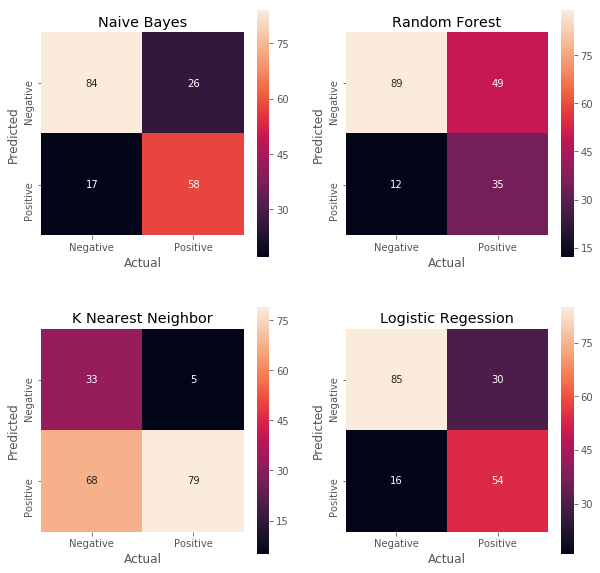

In [205]:
nb_train_acc = accuracy_score(y_res, nb_train_preds)
nb_test_acc = accuracy_score(y_test, nb_test_preds)
nb_train_f1 = f1_score(y_res, nb_train_preds, average='weighted')
nb_test_f1 = f1_score(y_test, nb_test_preds, average='weighted')
rf_train_acc = accuracy_score(y_res, rf_train_preds)
rf_test_acc = accuracy_score(y_test, rf_test_preds)
rf_train_f1 = f1_score(y_res, rf_train_preds, average='weighted')
rf_test_f1 = f1_score(y_test, rf_test_preds, average='weighted')
knn_train_acc = accuracy_score(y_res, knn_train_preds)
knn_test_acc = accuracy_score(y_test, knn_test_preds)
knn_train_f1 = f1_score(y_res, knn_train_preds, average='weighted')
knn_test_f1 = f1_score(y_test, knn_test_preds, average='weighted')
lr_train_acc = accuracy_score(y_res, lr_train_preds)
lr_test_acc = accuracy_score(y_test, lr_test_preds)
lr_train_f1 = f1_score(y_res, lr_train_preds, average='weighted')
lr_test_f1 = f1_score(y_test, lr_test_preds, average='weighted')

# note that the the high negative class is being treated as the target 

print("Multinomial Naive Bayes")
print("Training Accuracy:", nb_train_acc)
print("Training F1:", nb_train_f1)
print("Testing Accuracy:", nb_test_acc)
print("Testing F1:", nb_test_f1)
print("\n")
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
cm = confusion_matrix(y_test, nb_test_preds)
sns.heatmap(cm.T, square=True, annot=True, yticklabels=['Negative', 'Positive'], xticklabels=['Negative', 'Positive', ])
plt.title('Naive Bayes')
plt.xlabel('Actual')
plt.ylabel('Predicted')

print('Random Forest')
print("Training Accuracy:", rf_train_acc)
print("Training F1:", nb_train_f1)
print("Testing Accuracy:", rf_test_acc)
print("Testing F1:", rf_test_f1)
print("\n")
plt.subplot(2,2,2)
cm = confusion_matrix(y_test, rf_test_preds)
sns.heatmap(cm.T, square=True, annot=True, yticklabels=['Negative', 'Positive'], xticklabels=['Negative', 'Positive', ])
plt.title('Random Forest')
plt.xlabel('Actual')
plt.ylabel('Predicted')

print('K Nearest Neighbors')
print("Training Accuracy:", knn_train_acc)
print("Training F1:", knn_train_f1)
print("Testing Accuracy:", knn_test_acc)
print("Testing F1:", knn_test_f1)
print("\n")
plt.subplot(2,2,3)
cm = confusion_matrix(y_test, knn_test_preds)
sns.heatmap(cm.T, square=True, annot=True, yticklabels=['Negative', 'Positive'], xticklabels=['Negative', 'Positive'])
plt.title('K Nearest Neighbor')
plt.xlabel('Actual')
plt.ylabel('Predicted')

print('Logistic Regression')
print("Training Accuracy:", lr_train_acc)
print("Training F1:", lr_train_f1)
print("Testing Accuracy:", lr_test_acc)
print("Testing F1:", lr_test_f1)
plt.subplot(2,2,4)
cm = confusion_matrix(y_test, lr_test_preds)
sns.heatmap(cm.T, square=True, annot=True, yticklabels=['Negative', 'Positive'], xticklabels=['Negative', 'Positive'])
plt.title('Logistic Regession')
plt.xlabel('Actual')
plt.ylabel('Predicted')

In [206]:
df = pd.DataFrame({"true": y_test, "predicted":lr_test_preds})
len(df.loc[(df.true==0) & (df.predicted==1)])

16

## All valence labels

In [23]:
X = corpus_df['word_tag_tuples']
y = valence_df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=1)


In [24]:
vectorizer = TfidfVectorizer()
tf_idf_X_train = vectorizer.fit_transform(X_train)
tf_idf_X_test = vectorizer.transform(X_test)
tf_idf_X_train.shape


(750, 2257)

In [25]:
# smt = SMOTE(sampling_strategy='not majority')
# X_res, y_res = smt.fit_resample(tf_idf_X_train, y_train)
# X_res.shape


In [28]:
nb_classifier = MultinomialNB(fit_prior=True)
rf_classifier = RandomForestClassifier(max_depth=25, class_weight='balanced')
knn_classifier = KNeighborsClassifier(n_neighbors=5)
lr_classifier = LogisticRegression(C=1e10, class_weight='balanced')

nb_classifier.fit(tf_idf_X_train, y_train)
nb_train_preds = nb_classifier.predict(tf_idf_X_train)
nb_test_preds = nb_classifier.predict(tf_idf_X_test)

rf_classifier.fit(tf_idf_X_train, y_train)
rf_train_preds = rf_classifier.predict(tf_idf_X_train)
rf_test_preds = rf_classifier.predict(tf_idf_X_test)

knn_classifier.fit(tf_idf_X_train, y_train)
knn_train_preds = knn_classifier.predict(tf_idf_X_train)
knn_test_preds = knn_classifier.predict(tf_idf_X_test)

lr_classifier.fit(tf_idf_X_train, y_train)
lr_train_preds = lr_classifier.predict(tf_idf_X_train)
lr_test_preds = lr_classifier.predict(tf_idf_X_test)

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Multinomial Naive Bayes
Training Accuracy: 0.952
Training F1: 0.9512064363014597
Testing Accuracy: 0.564
Testing F1: 0.5206296416853963


Random Forest
Training Accuracy: 0.6693333333333333
Training F1: 0.9512064363014597
Testing Accuracy: 0.464
Testing F1: 0.4416789006200771


K Nearest Neighbors
Training Accuracy: 0.6813333333333333
Training F1: 0.6654180348350011
Testing Accuracy: 0.52
Testing F1: 0.48127783327783324


Logistic Regression
Training Accuracy: 0.9986666666666667
Training F1: 0.9986670376384609
Testing Accuracy: 0.556
Testing F1: 0.5494451021988123


Text(373.36363636363626, 0.5, 'Predicted')

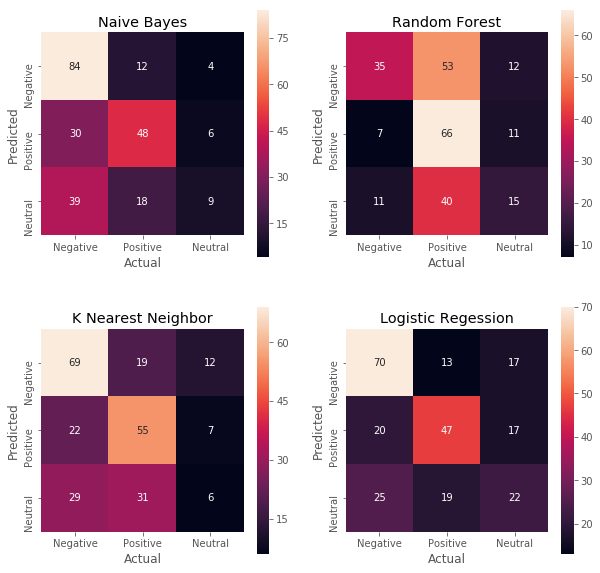

In [30]:
nb_train_acc = accuracy_score(y_train, nb_train_preds)
nb_test_acc = accuracy_score(y_test, nb_test_preds)
nb_train_f1 = f1_score(y_train, nb_train_preds, average='weighted')
nb_test_f1 = f1_score(y_test, nb_test_preds, average='weighted')
rf_train_acc = accuracy_score(y_train, rf_train_preds)
rf_test_acc = accuracy_score(y_test, rf_test_preds)
rf_train_f1 = f1_score(y_train, rf_train_preds, average='weighted')
rf_test_f1 = f1_score(y_test, rf_test_preds, average='weighted')
knn_train_acc = accuracy_score(y_train, knn_train_preds)
knn_test_acc = accuracy_score(y_test, knn_test_preds)
knn_train_f1 = f1_score(y_train, knn_train_preds, average='weighted')
knn_test_f1 = f1_score(y_test, knn_test_preds, average='weighted')
lr_train_acc = accuracy_score(y_train, lr_train_preds)
lr_test_acc = accuracy_score(y_test, lr_test_preds)
lr_train_f1 = f1_score(y_train, lr_train_preds, average='weighted')
lr_test_f1 = f1_score(y_test, lr_test_preds, average='weighted')

# note that the the high negative class is being treated as the target 

print("Multinomial Naive Bayes")
print("Training Accuracy:", nb_train_acc)
print("Training F1:", nb_train_f1)
print("Testing Accuracy:", nb_test_acc)
print("Testing F1:", nb_test_f1)
print("\n")
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
cm = confusion_matrix(y_test, nb_test_preds)
sns.heatmap(cm, square=True, annot=True, yticklabels=['Negative', 'Positive', 'Neutral'], xticklabels=['Negative', 'Positive', 'Neutral'])
plt.title('Naive Bayes')
plt.xlabel('Actual')
plt.ylabel('Predicted')

print('Random Forest')
print("Training Accuracy:", rf_train_acc)
print("Training F1:", nb_train_f1)
print("Testing Accuracy:", rf_test_acc)
print("Testing F1:", rf_test_f1)
print("\n")
plt.subplot(2,2,2)
cm = confusion_matrix(y_test, rf_test_preds)
sns.heatmap(cm, square=True, annot=True, yticklabels=['Negative', 'Positive', 'Neutral'], xticklabels=['Negative', 'Positive', 'Neutral'])
plt.title('Random Forest')
plt.xlabel('Actual')
plt.ylabel('Predicted')

print('K Nearest Neighbors')
print("Training Accuracy:", knn_train_acc)
print("Training F1:", knn_train_f1)
print("Testing Accuracy:", knn_test_acc)
print("Testing F1:", knn_test_f1)
print("\n")
plt.subplot(2,2,3)
cm = confusion_matrix(y_test, knn_test_preds)
sns.heatmap(cm, square=True, annot=True, yticklabels=['Negative', 'Positive', 'Neutral'], xticklabels=['Negative', 'Positive', 'Neutral'])
plt.title('K Nearest Neighbor')
plt.xlabel('Actual')
plt.ylabel('Predicted')

print('Logistic Regression')
print("Training Accuracy:", lr_train_acc)
print("Training F1:", lr_train_f1)
print("Testing Accuracy:", lr_test_acc)
print("Testing F1:", lr_test_f1)
plt.subplot(2,2,4)
cm = confusion_matrix(y_test, lr_test_preds)
sns.heatmap(cm, square=True, annot=True, yticklabels=['Negative', 'Positive', 'Neutral'], xticklabels=['Negative', 'Positive', 'Neutral'])
plt.title('Logistic Regession')
plt.xlabel('Actual')
plt.ylabel('Predicted')

In [212]:
df = pd.DataFrame({"true": y_test, "predicted":lr_test_preds})
len(df.loc[(df.true==1) & (df.predicted==0)])

20

## Emotion categories

In [10]:
X = corpus_df_emotion['word_tag_tuples']
y = emotion_df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=1)


In [11]:
vectorizer = TfidfVectorizer()
tf_idf_X_train = vectorizer.fit_transform(X_train)
tf_idf_X_test = vectorizer.transform(X_test)
tf_idf_X_train.shape


(746, 1)

In [12]:
smt = SMOTE(sampling_strategy='not majority')
X_res, y_res = smt.fit_resample(tf_idf_X_train, y_train)
X_res.shape


(1614, 1)

In [18]:
nb_classifier = MultinomialNB(fit_prior=True)
rf_classifier = RandomForestClassifier(max_depth=25, class_weight='balanced')
knn_classifier = KNeighborsClassifier(n_neighbors=5)
lr_classifier = LogisticRegression(C=1e10, class_weight='balanced')

nb_classifier.fit(X_res, y_res)
nb_train_preds = nb_classifier.predict(X_res)
nb_test_preds = nb_classifier.predict(tf_idf_X_test)

rf_classifier.fit(X_res, y_res)
rf_train_preds = rf_classifier.predict(X_res)
rf_test_preds = rf_classifier.predict(tf_idf_X_test)

knn_classifier.fit(X_res, y_res)
knn_train_preds = knn_classifier.predict(X_res)
knn_test_preds = knn_classifier.predict(tf_idf_X_test)

lr_classifier.fit(X_res, y_res)
lr_train_preds = lr_classifier.predict(X_res)
lr_test_preds = lr_classifier.predict(tf_idf_X_test)

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:143

Multinomial Naive Bayes
Training Accuracy: 0.16666666666666666
Training F1: 0.04761904761904761
Testing Accuracy: 0.0642570281124498
Testing F1: 0.007759339243767523


Random Forest
Training Accuracy: 0.16666666666666666
Training F1: 0.04761904761904761
Testing Accuracy: 0.3614457831325301
Testing F1: 0.1919181149376266


K Nearest Neighbors
Training Accuracy: 0.16666666666666666
Training F1: 0.04761904761904761
Testing Accuracy: 0.024096385542168676
Testing F1: 0.0011339475549255846


Logistic Regression
Training Accuracy: 0.16666666666666666
Training F1: 0.04761904761904761
Testing Accuracy: 0.18473895582329317
Testing F1: 0.057613504866925326


Text(373.36363636363626, 0.5, 'Predicted')

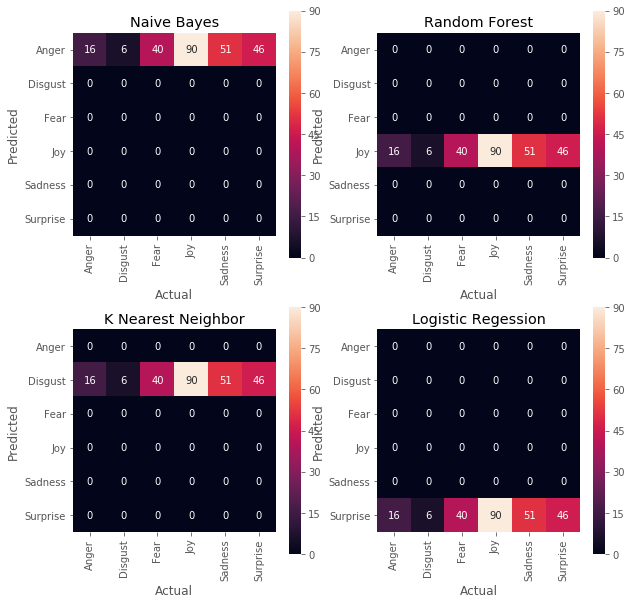

In [16]:
nb_train_acc = accuracy_score(y_res, nb_train_preds)
nb_test_acc = accuracy_score(y_test, nb_test_preds)
nb_train_f1 = f1_score(y_res, nb_train_preds, average='weighted')
nb_test_f1 = f1_score(y_test, nb_test_preds, average='weighted')
rf_train_acc = accuracy_score(y_res, rf_train_preds)
rf_test_acc = accuracy_score(y_test, rf_test_preds)
rf_train_f1 = f1_score(y_res, rf_train_preds, average='weighted')
rf_test_f1 = f1_score(y_test, rf_test_preds, average='weighted')
knn_train_acc = accuracy_score(y_res, knn_train_preds)
knn_test_acc = accuracy_score(y_test, knn_test_preds)
knn_train_f1 = f1_score(y_res, knn_train_preds, average='weighted')
knn_test_f1 = f1_score(y_test, knn_test_preds, average='weighted')
lr_train_acc = accuracy_score(y_res, lr_train_preds)
lr_test_acc = accuracy_score(y_test, lr_test_preds)
lr_train_f1 = f1_score(y_res, lr_train_preds, average='weighted')
lr_test_f1 = f1_score(y_test, lr_test_preds, average='weighted')

# note that the the high negative class is being treated as the target 

print("Multinomial Naive Bayes")
print("Training Accuracy:", nb_train_acc)
print("Training F1:", nb_train_f1)
print("Testing Accuracy:", nb_test_acc)
print("Testing F1:", nb_test_f1)
print("\n")
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
cm = confusion_matrix(y_test, nb_test_preds)
sns.heatmap(cm.T, square=True, annot=True, yticklabels=['Anger', 'Disgust', 'Fear', 'Joy', 'Sadness', 'Surprise'], xticklabels=['Anger', 'Disgust', 'Fear', 'Joy', 'Sadness', 'Surprise'])
plt.title('Naive Bayes')
plt.xlabel('Actual')
plt.ylabel('Predicted')

print('Random Forest')
print("Training Accuracy:", rf_train_acc)
print("Training F1:", nb_train_f1)
print("Testing Accuracy:", rf_test_acc)
print("Testing F1:", rf_test_f1)
print("\n")
plt.subplot(2,2,2)
cm = confusion_matrix(y_test, rf_test_preds)
sns.heatmap(cm.T, square=True, annot=True, yticklabels=['Anger', 'Disgust', 'Fear', 'Joy', 'Sadness', 'Surprise'], xticklabels=['Anger', 'Disgust', 'Fear', 'Joy', 'Sadness', 'Surprise'])
plt.title('Random Forest')
plt.xlabel('Actual')
plt.ylabel('Predicted')

print('K Nearest Neighbors')
print("Training Accuracy:", knn_train_acc)
print("Training F1:", knn_train_f1)
print("Testing Accuracy:", knn_test_acc)
print("Testing F1:", knn_test_f1)
print("\n")
plt.subplot(2,2,3)
cm = confusion_matrix(y_test, knn_test_preds)
sns.heatmap(cm.T, square=True, annot=True, yticklabels=['Anger', 'Disgust', 'Fear', 'Joy', 'Sadness', 'Surprise'], xticklabels=['Anger', 'Disgust', 'Fear', 'Joy', 'Sadness', 'Surprise'])
plt.title('K Nearest Neighbor')
plt.xlabel('Actual')
plt.ylabel('Predicted')

print('Logistic Regression')
print("Training Accuracy:", lr_train_acc)
print("Training F1:", lr_train_f1)
print("Testing Accuracy:", lr_test_acc)
print("Testing F1:", lr_test_f1)
plt.subplot(2,2,4)
cm = confusion_matrix(y_test, lr_test_preds)
sns.heatmap(cm.T, square=True, annot=True, yticklabels=['Anger', 'Disgust', 'Fear', 'Joy', 'Sadness', 'Surprise'], xticklabels=['Anger', 'Disgust', 'Fear', 'Joy', 'Sadness', 'Surprise'])
plt.title('Logistic Regession')
plt.xlabel('Actual')
plt.ylabel('Predicted')

In [17]:
df = pd.DataFrame({"true": y_test, "predicted":lr_test_preds})
len(df.loc[(df.true==4) & (df.predicted==3)])

0

## Neural Network: Strong Pos/Neg Valence 

In [174]:
y = valence_df['label'].loc[(valence_df['label']==1)|(valence_df['label']==0)]
X = corpus_df['text'].iloc[y.index]

# from keras.utils import to_categorical
# y_binary = to_categorical(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=1)

vectorizer = TfidfVectorizer()
tf_idf_X_train = vectorizer.fit_transform(X_train)
tf_idf_X_test = vectorizer.transform(X_test)

smt = SMOTE(sampling_strategy='not majority')
X_res, y_res = smt.fit_resample(tf_idf_X_train, y_train)
y_res = pd.get_dummies(y_res).values

num_features = 1615
num_classes = 2

model = Sequential()
# first layer, includes input shape
model.add(Dense(300, activation='relu', input_shape=(num_features, )))
model.add(BatchNormalization())
model.add(Dropout(0.5))
# second layer
model.add(Dense(150, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
# final layer with the number of classes as the number of outputs
# uses a softmax classifier, which is standard for NLP
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='mean_squared_error',
              optimizer=Adam(lr=.002, decay=.00001),
              metrics=['accuracy'])
              
history = model.fit(X_res, 
                    y_res,
                    epochs=50,
                    batch_size=100,
                    validation_data=(tf_idf_X_test, pd.get_dummies(y_test)))

Train on 602 samples, validate on 185 samples
Epoch 1/50
602/602 [==============================] - 1s 2ms/step - loss: 0.3772 - acc: 0.5033 - val_loss: 0.2622 - val_acc: 0.5946
Epoch 2/50
602/602 [==============================] - 0s 236us/step - loss: 0.1943 - acc: 0.7243 - val_loss: 0.2173 - val_acc: 0.6649
Epoch 3/50
602/602 [==============================] - 0s 203us/step - loss: 0.1185 - acc: 0.8372 - val_loss: 0.2019 - val_acc: 0.6811
Epoch 4/50
602/602 [==============================] - 0s 275us/step - loss: 0.0694 - acc: 0.9020 - val_loss: 0.1878 - val_acc: 0.7297
Epoch 5/50
602/602 [==============================] - 0s 288us/step - loss: 0.0468 - acc: 0.9419 - val_loss: 0.1802 - val_acc: 0.7405
Epoch 6/50
602/602 [==============================] - 0s 229us/step - loss: 0.0305 - acc: 0.9601 - val_loss: 0.1746 - val_acc: 0.7568
Epoch 7/50
602/602 [==============================] - 0s 246us/step - loss: 0.0161 - acc: 0.9701 - val_loss: 0.1619 - val_acc: 0.7784
Epoch 8/50
602/602

185/185 [==============================] - 0s 134us/step
[0.17044270328573277, 0.794594596205531]


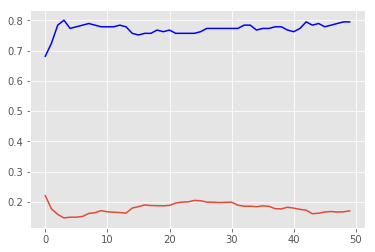

In [150]:
print(model.evaluate(tf_idf_X_test, pd.get_dummies(y_test)))

plt.plot(history.history['val_acc'], color='blue')
plt.plot(history.history['val_loss'])

## Neural Network: All Valence Labels

In [151]:
X = corpus_df['text']
y = valence_df['label']

from keras.utils import to_categorical
y_binary = to_categorical(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_binary, stratify=y, random_state=42)

vectorizer = TfidfVectorizer()
tf_idf_X_train = vectorizer.fit_transform(X_train)
tf_idf_X_test = vectorizer.transform(X_test)

smt = SMOTE(sampling_strategy='not majority')
X_res, y_res = smt.fit_resample(tf_idf_X_train, y_train)
X_res.shape

num_features = 2015
num_classes = 3

model = Sequential()
# first layer, includes input shape
model.add(Dense(300, activation='relu', input_shape=(num_features, )))
model.add(BatchNormalization())
model.add(Dropout(0.2))
# second layer
model.add(Dense(150, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
# final layer with the number of classes as the number of outputs
# uses a softmax classifier, which is standard for NLP
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='mean_squared_error',
              optimizer=Adam(lr=.002, decay=.00001),
              metrics=['accuracy'])
              
history = model.fit(X_res, 
                    y_res,
                    epochs=50,
                    batch_size=100,
                    validation_data=(tf_idf_X_test, y_test))

Train on 903 samples, validate on 250 samples
Epoch 1/50
903/903 [==============================] - 2s 2ms/step - loss: 0.2396 - acc: 0.4917 - val_loss: 0.2471 - val_acc: 0.4960
Epoch 2/50
903/903 [==============================] - 0s 290us/step - loss: 0.0668 - acc: 0.8616 - val_loss: 0.2328 - val_acc: 0.5160
Epoch 3/50
903/903 [==============================] - 0s 234us/step - loss: 0.0231 - acc: 0.9535 - val_loss: 0.2329 - val_acc: 0.5360
Epoch 4/50
903/903 [==============================] - 0s 273us/step - loss: 0.0118 - acc: 0.9801 - val_loss: 0.2272 - val_acc: 0.5440
Epoch 5/50
903/903 [==============================] - 0s 321us/step - loss: 0.0074 - acc: 0.9900 - val_loss: 0.2245 - val_acc: 0.5480
Epoch 6/50
903/903 [==============================] - 0s 245us/step - loss: 0.0048 - acc: 0.9922 - val_loss: 0.2215 - val_acc: 0.5280
Epoch 7/50
903/903 [==============================] - 0s 242us/step - loss: 0.0032 - acc: 0.9945 - val_loss: 0.2205 - val_acc: 0.5520
Epoch 8/50
903/903

250/250 [==============================] - 0s 227us/step
[0.2488353636264801, 0.5400000028610229]


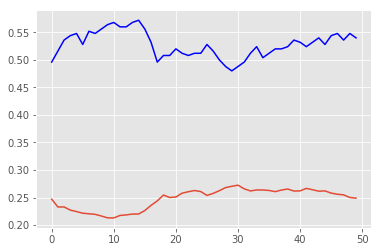

In [152]:
print(model.evaluate(tf_idf_X_test, y_test))

plt.plot(history.history['val_acc'], color='blue')
plt.plot(history.history['val_loss'])

## Neural Network: Emotion Labels

In [153]:
X = corpus_df_emotion['text']
y = emotion_df['label']

from keras.utils import to_categorical
y_binary = to_categorical(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_binary, stratify=y, random_state=42)

vectorizer = TfidfVectorizer()
tf_idf_X_train = vectorizer.fit_transform(X_train)
tf_idf_X_test = vectorizer.transform(X_test)

smt = SMOTE(sampling_strategy='not majority')
X_res, y_res = smt.fit_resample(tf_idf_X_train, y_train)
X_res.shape

num_features = 2022
num_classes = 6

model = Sequential()
# first layer, includes input shape
model.add(Dense(300, activation='relu', input_shape=(num_features, )))
model.add(BatchNormalization())
model.add(Dropout(0.2))
# second layer
model.add(Dense(150, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
# final layer with the number of classes as the number of outputs
# uses a softmax classifier, which is standard for NLP
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='mean_squared_error',
              optimizer=Adam(lr=.002, decay=.00001),
              metrics=['accuracy'])
              
history = model.fit(X_res, 
                    y_res,
                    epochs=50,
                    batch_size=100,
                    validation_data=(tf_idf_X_test, y_test))

Train on 1614 samples, validate on 249 samples
Epoch 1/50
1614/1614 [==============================] - 2s 1ms/step - loss: 0.0991 - acc: 0.5446 - val_loss: 0.1433 - val_acc: 0.3574
Epoch 2/50
1614/1614 [==============================] - 1s 323us/step - loss: 0.0213 - acc: 0.9226 - val_loss: 0.1340 - val_acc: 0.4217
Epoch 3/50
1614/1614 [==============================] - 1s 316us/step - loss: 0.0067 - acc: 0.9765 - val_loss: 0.1333 - val_acc: 0.4217
Epoch 4/50
1614/1614 [==============================] - 0s 299us/step - loss: 0.0021 - acc: 0.9926 - val_loss: 0.1344 - val_acc: 0.4418
Epoch 5/50
1614/1614 [==============================] - 0s 288us/step - loss: 0.0011 - acc: 0.9975 - val_loss: 0.1341 - val_acc: 0.4538
Epoch 6/50
1614/1614 [==============================] - 0s 277us/step - loss: 7.0222e-04 - acc: 0.9975 - val_loss: 0.1342 - val_acc: 0.4699
Epoch 7/50
1614/1614 [==============================] - 0s 287us/step - loss: 6.5609e-04 - acc: 0.9988 - val_loss: 0.1362 - val_acc: 0.

249/249 [==============================] - 0s 146us/step
[0.1642139646781975, 0.4337349395196601]


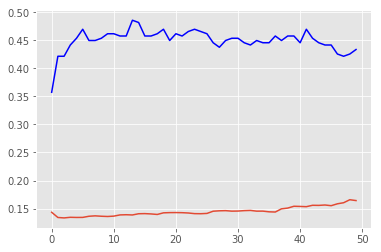

In [154]:
print(model.evaluate(tf_idf_X_test, y_test))

plt.plot(history.history['val_acc'], color='blue')
plt.plot(history.history['val_loss'])